In [1]:
import torch
import numpy as np
from numpy import linalg as LA
import pickle
import scipy.io
import logging
import pdb
import time
import sys
sys.path.append("..")
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
def sparsity(matrix):
    matrix = matrix.detach().clone()
    ni = torch.tensor(matrix.shape[0], device=matrix.device)

    # Get Indices of columns with all-0 vectors.
    zero_col_ind = (abs(matrix.sum(0) - 0) < 2.22e-16).nonzero().reshape(-1)  
    spx_c = (torch.sqrt(ni) - torch.norm(matrix,1, dim=0) / torch.norm(matrix,2, dim=0)) / (torch.sqrt(ni) - 1)

    if len(zero_col_ind) != 0:
        spx_c[zero_col_ind] = 1  # Sparsity = 1 if column already zero vector.
    
    if matrix.dim() > 1:   
        # sps_avg =  spx_c.sum() / matrix.shape[1]
        sps_avg = spx_c.mean()
    elif matrix.dim() == 1:  # If not a matrix but a column vector!
        sps_avg =  spx_c    
    return sps_avg

In [4]:
def checkCritical(matrix, critval_list, precision=1e-6):
    max_elems = torch.max(matrix, 0)[0]

    ind_crit_bool = (abs(matrix - max_elems) < precision)
    crit_points = matrix * ind_crit_bool

    num_crit_points = torch.sum(ind_crit_bool, dim=0)

    # Boolean of vector cols with non-trivial critical values
    crit_cols = torch.where((num_crit_points.float() > 1).cuda(device), torch.ones(matrix.shape[1], device=device), \
                            torch.zeros(matrix.shape[1], device=device))

    # getting non-trivial critical values
    critval_list = max_elems[crit_cols.bool()]

    return critval_list, max_elems

In [5]:
# torch.where(num_crit_points.float() > 1, arg1, arg2)

In [6]:
def gmu(matrix, xp_mat, mu=0):
    vgmu = 0
    gradg = 0
    matrix = torch.abs(matrix)
    xp_mat = torch.zeros([matrix.shape[0], matrix.shape[1]]).to(device)
    glist = []

    gsp_iter = 0

    # ------------------------------- Previous For Loop --------------------------------------
    ni = matrix.shape[0]
    betai = 1 / (torch.sqrt(torch.tensor(ni, dtype=torch.float32, device=device)) - 1)

    xp_mat = matrix - (mu * betai)
    indtp = xp_mat > 0

    xp_mat.relu_()

    # outputs
    mnorm = torch.norm(xp_mat, dim=0)
    mnorm_inf = mnorm.clone()
    mnorm_inf[mnorm_inf == 0] = float("Inf")

    col_norm_mask = (mnorm > 0)

    # mat_mask =  (col_norm_mask.float().view(1,784) * torch.ones(300,1))
    mat_mask = (col_norm_mask.float().view(1, matrix.shape[1]) * torch.ones(matrix.shape[0], 1,device=device))

    nip = torch.sum(xp_mat > 0, dim=0)  # columnwise number of values > 0

    # needs the if condition mnorm> 0 (it's included)
    # Terms in the Gradient Calculation
    term2 = torch.pow(torch.sum(xp_mat, dim=0), 2)
    mnorm_inv = torch.pow(mnorm_inf, -1)
    mnorm_inv3 = torch.pow(mnorm_inf, -3)

    # The column vectors with norm mnorm == 0 zero, should not contribute to the gradient sum.
    # In the published algorithm, we only calculate gradients for condition: mnorm> 0
    # To vectorize, we include in the matrix columns where mnorm == 0, but we manually replace
    # the inf after divide by zero with 0, so that the grad of that column becomes 0 and
    # doesn't contribute to the sum.
    # mnorm_inv[torch.isinf(mnorm_inv)] = 0
    # mnorm_inv3[torch.isinf(mnorm_inv3)] = 0

    # Calculate Gradient
    gradg_mat = torch.pow(betai, 2) * (-nip * mnorm_inv + term2 * mnorm_inv3)
    gradg = torch.sum(gradg_mat)

    # vgmu calculation
    ## When indtp is not empty (the columns whose norm are not zero)
    # xp_mat /= mnorm
    xp_mat[:, col_norm_mask] /= mnorm[col_norm_mask]

    ## When indtp IS empty (the columns whose norm ARE zero)
    max_elem_rows = torch.argmax(matrix, dim=0)[~col_norm_mask]  # The Row Indices where maximum of that column occurs
    xp_mat[max_elem_rows, ~col_norm_mask] = 1

    # vgmu computation
    vgmu_mat = betai * torch.sum(xp_mat, dim=0)
    vgmu = torch.sum(vgmu_mat)

    return vgmu, xp_mat, gradg

In [103]:
def groupedsparseproj(matrix, sps, precision=1e-6, linrat=0.9):
    # sps = 0.9 ;  precision=1e-6; linrat=0.9
    global device
    # print(f"The device from GPU-proj matrix: {str(matrix.device)}")
    if str(matrix.device) != 'cpu':
        device = torch.device('cuda')
        # print("The device is cuda")
    if str(matrix.device) == 'cpu':
        device = torch.device('cpu')
        # print("The device is cpu")
    if str(matrix.device) == 'cpu':
        print("Device neither CPU nor CUDA! Please check!")

    epsilon = 10e-15
    k = 0
    muup0 = 0
    r = matrix.shape[1]  # No of Columns

    critmu = torch.tensor([])
    critval_list = []

    vgmu = torch.zeros(1, device=device)
    # maxxi_list = []

    # These operations were inside the loop, but doesn't need to be.
    matrix_sign = torch.sign(matrix)
    pos_matrix = matrix_sign * matrix
    xp_mat = torch.zeros([matrix.shape[0], matrix.shape[1]]).to(device)
    ni = matrix.shape[0]

    # -------------------------------------------------------------------------------
    # Check Critical Points
    k = r * np.sqrt(ni) / (np.sqrt(ni) - 1)
    # check critical values of mu where g(mu) is discontinuous, that is,
    # where the two (or more) largest entries of x{i} are equal to one another.
    critical_val, max_xi = checkCritical(pos_matrix, critval_list)
    muup0 = max(max_xi * (np.sqrt(ni) - 1))
    critmu = torch.tensor(critval_list) * (np.sqrt(ni) - 1)

    k = k - r * sps
    vgmu, xp_mat, gradg = gmu(pos_matrix, xp_mat, 0)

    if vgmu < k:
        xp_mat = matrix
        gxpmu = vgmu
        numiter = 0
        print(f"Feasible at iter: {numiter}")
        return xp_mat, 'No Info'
    else:
        numiter = 0
        mulow = 0
        glow = vgmu
        muup = muup0
        # Initialization on mu using 0, it seems to work best because the
        # slope at zero is rather steep while it is gets falt for large mu
        newmu = 0
        gnew = glow
        gpnew = gradg  # g'(0)
        delta = muup - mulow
        switch = True

        # pdb.set_trace()
        while abs(gnew - k) > precision * r and numiter < 100:
            oldmu = newmu
            # % Secant method:
            # % newmu = mulow + (k-glow)*(muup-mulow)/(gup-glow);

            # % Bisection:
            # % newmu = (muup+mulow)/2;
            # % Newton:
            newmu = oldmu + (k - gnew) / (gpnew + epsilon)

            if (newmu >= muup) or (newmu <= mulow):  # If Newton goes out of the interval, use bisection
                newmu = (mulow + muup) / 2

            # print( 'Value of numiter: ' + str(numiter))
            gnew, xnew, gpnew = gmu(matrix, xp_mat, newmu)

            if gnew < k:
                gup = gnew; xup = xnew; muup = newmu; 
            else:
                glow = gnew; mulow = xnew; mulow = newmu;
                
            # Guarantees linear convergence
            if (muup - mulow) > linrat * delta and abs(oldmu - newmu) < (1 - linrat) * delta:
                newmu = (mulow + muup) / 2
                gnew, xnew, gpnew = gmu(matrix, xp_mat, newmu)

                if gnew < k:
                    gup = gnew; xup = xnew; muup = newmu
                else:
                    glow = gnew; mulow = xnew; mulow = newmu
                    
                numiter += 1
            numiter += 1

            if critmu.shape[0] != 0 and abs(mulow - muup) < abs(newmu) * precision and \
                    min(abs(newmu - critmu)) < precision * newmu:
                print('The objective function is discontinuous around mu^*.')
                xp = xnew
                gxpmu = gnew
        
            xp_mat = xnew

        # try:
        #     xp_mat = xnew
        # except:
        #     # torch.save(matrix, 'prob_tensor.pt')
        #     print(f'num_iter: {numiter}')
        #     # print('FAILED HERE')
        #     # lhs = abs(gnew - k)
        #     # rhs =  precision * r
        #     print(f"gnew: {gnew}, k: {k}, precision: {precision}, r: {r}")

        gxpmu = gnew

    alpha_mat = torch.matmul(xp_mat.T, pos_matrix)
 

    alpha = torch.diagonal(alpha_mat)
    xp_mat = alpha * (matrix_sign * xp_mat)

    outinfo = { 'numiter': numiter,
                'gxpmu':gxpmu, 
                'newmu':newmu
                }

    return xp_mat, outinfo

In [88]:
def load_matrix_debug(path="./matrices/matrix_3.pkl"):
    with open(path, "rb") as fpA:  # Pickling
        matrix = pickle.load(fpA)
        # matrix = matrix.detach()
        matrix = torch.from_numpy(matrix)
    return matrix

In [104]:
# matrix = load_matrix_debug()
mat = torch.load('./matrices/prob_tensor.pt')
# scipy.io.savemat('matrix.mat', mdict={'arr': mat.cpu().numpy()})

In [107]:
out, _ = groupedsparseproj(mat, sps=0.82, precision=1e-6, linrat=0.9)

In [108]:
sparsity(out)

tensor(0.8200, device='cuda:0')

-----------------
## Visualization of Matrix Projection

In [57]:
mat = torch.tensor([ [1,2,14,9,-14,9,-1,5,-11,7],
                        [8,2,-6,-13,-24,-13,-6,1,4,-11],
                        [-3,-2,3,-1,-6,3,18,-2,-2,-19] ], device=device, dtype=torch.float).T

In [58]:
n = mat.shape[0]
r = mat.shape[1]
k0 = r * np.sqrt(n)/(np.sqrt(n) - 1)

In [59]:
# Projection 1 with SPS 0.8
out_8, info_8 = groupedsparseproj(mat, sps=0.8, precision=1e-4, linrat=0.9)
k1 =  k0 - r * 0.8
out_9, info_9 = groupedsparseproj(mat, sps=0.9, precision=1e-4, linrat=0.9)
k2 =  k0 - r * 0.9

In [60]:
mumax=40
mu_range = np.linspace(0,40,501)

vgmu_l = list()
for mu in np.nditer(mu_range):
    vgmu, _, _ = gmu(mat.abs(), mat, mu=float(mu))
    vgmu_l.append(vgmu.item())

In [61]:
newmu1 = info_8['newmu'].item()
newmu2 = info_9['newmu'].item()

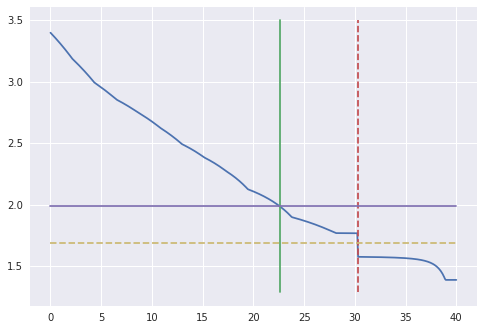

In [62]:
plt.style.use('seaborn')
plt.plot(mu_range, vgmu_l)
plt.plot([newmu1, newmu1], [min(vgmu_l)-0.1, max(vgmu_l)+0.1])
plt.plot([newmu2, newmu2], [min(vgmu_l)-0.1, max(vgmu_l)+0.1], '--')
plt.plot([0, mumax], [k1, k1])
plt.plot([0, mumax], [k2, k2], '--')

